In [245]:
import argparse
import numpy as np
import pandas as pd
import os
import random
import torch
import torch.nn as nn
import datetime
import time
import matplotlib.pyplot as plt
from torchinfo import summary
import yaml
import json
import sys
import glob
import copy
from tqdm import tqdm, trange
from torch.optim.lr_scheduler import LambdaLR, MultiStepLR, SequentialLR

sys.path.append("..")
from lib.utils import (
    MaskedMAELoss,
    MaskedHuberLoss,
    print_log,
    seed_everything,
    set_cpu_num,
    masked_mae_loss,
    CustomJSONEncoder,
    endpoint_adjacency,
    prop_graph_bce_loss,
)
from lib.metrics import RMSE_MAE_MAPE
from lib.data_prepare import get_dataloaders_from_index_data, load_inrix_data_with_details
from model.PropSTGformer import PropSTGformer
from functools import partial

In [246]:
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
DATASET = "PROPSTGFORMER_INRIX_MANHATTAN"
SCALER = None

In [252]:
CHECKPOINT = "../saved_models/PropSTGformer-PROPSTGFORMER_INRIX_MANHATTAN-2025-10-27-21-42-18.pt"

In [248]:
dataset = DATASET.upper()
data_path = f"../data/{dataset}"
model_name = PropSTGformer.__name__
with open(f"{model_name}.yaml", "r") as f:
    cfg = yaml.safe_load(f)
cfg = cfg[dataset]

In [249]:
# ------------------------------- make log file ------------------------------ #

now = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
log_path = f"../logs/"
if not os.path.exists(log_path):
    os.makedirs(log_path)
log = os.path.join(log_path, f"{model_name}-{dataset}-{now}.log")
log = open(log, "a", encoding="utf-8")
log.seek(0)
log.truncate()

0

In [250]:
# ------------------------------- load dataset ------------------------------- #

print_log(dataset, log=log)
if 'INRIX' in dataset:
    (trainset_loader, valset_loader, testset_loader, SCALER, adj_mx, gdf, _) = (
        load_inrix_data_with_details(
            "/home/dachuan/Productivities/Spectral GAT/NY/adj_manhattan.npy",
            "/home/dachuan/Productivities/Spectral GAT/SPGAT/Data/speed_19_Manhattan_5min_py36",
            "/home/dachuan/Productivities/Spectral GAT/NY/Manhattan_FinalVersion.shp",
            "/home/dachuan/Productivities/Spectral GAT/NY/TMC_FinalVersion.csv",
            tod=cfg.get("time_of_day"),
            dow=cfg.get("day_of_week"),
            batch_size=cfg.get("batch_size", 64),
            history_seq_len=cfg.get("in_steps"),
            future_seq_len=cfg.get("out_steps"),
            log=log,
            train_ratio=cfg.get("train_size", 0.6),
            valid_ratio=cfg.get("val_size", 0.2),
            shift="store_true",
        )
    )

else:
    (trainset_loader, valset_loader, testset_loader, SCALER, adj_mx) = (
        get_dataloaders_from_index_data(
            data_path,
            tod=cfg.get("time_of_day"),
            dow=cfg.get("day_of_week"),
            batch_size=cfg.get("batch_size", 64),
            log=log,
            train_ratio=cfg.get("train_size", 0.6),
            valid_ratio=cfg.get("val_size", 0.2),
            shift="store_true",
        )
    )
print_log(log=log)

PROPSTGFORMER_INRIX_MANHATTAN
--- Building Sequences ---
--- Scaling Sequences ---
Trainset:	x-(63051, 1212, 12, 1)	y-(63051, 1212, 12, 1)
Valset:  	x-(21017, 1212, 12, 1)  	y-(21017, 1212, 12, 1)
Testset:	x-(21017, 1212, 12, 1)	y-(21017, 1212, 12, 1)



In [251]:
# Preparing adjacency matrices
supports = [torch.tensor(i).to(DEVICE) for i in adj_mx]
supports.append( torch.tensor(endpoint_adjacency(gdf, 20.0, 'EPSG: 32618')[0]).to(DEVICE) )
# Get lags 
prop_lags = cfg["lags"]

In [253]:
model = partial(PropSTGformer, supports=supports, num_lags=len(prop_lags))
model = model(**cfg["model_args"])
criterion = MaskedMAELoss()  # MaskedHuberLoss()
model = model.to(DEVICE)

# ------------------------------- load model ------------------------------- #
# latest_model = max(model_files, key=os.path.getctime)
latest_model = CHECKPOINT
print_log(f"Loading the latest model: {latest_model}", log=log)
model.load_state_dict(torch.load(latest_model))
model = model.to(DEVICE)

Loading the latest model: ../saved_models/PropSTGformer-PROPSTGFORMER_INRIX_MANHATTAN-2025-10-27-21-42-18.pt


In [254]:
@torch.no_grad()
def eval_model(model, valset_loader, criterion):
    model.eval()
    batch_loss_list = []
    for x_batch, y_batch in tqdm(valset_loader):
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        out_batch, _, _ = model(x_batch)
        # out_batch, y_batch: (B,T,N,C)
        out_batch = SCALER.inverse_transform(out_batch)
        B, T, N, C = out_batch.shape

        # ---- per-sample validity (B,) ----
        pred_finite = torch.isfinite(out_batch).all(dim=(1, 2, 3))
        true_finite = torch.isfinite(y_batch).all(dim=(1, 2, 3))
        mag_ok_pred = out_batch.abs().amax(dim=(1, 2, 3)) < 1e3
        mag_ok_true = y_batch.abs().amax(dim=(1, 2, 3)) < 1e3

        good_mask = pred_finite & true_finite & mag_ok_pred & mag_ok_true   # (B,)
        bad_mask  = ~good_mask

        # ---- per-road non-empty (B,N): True if GT not all-zero over (T,C) ----
        non_empty_mask = ~(y_batch == 0).all(dim=(1, 3))                    # (B,N)

        # ---- combine to element mask (B,T,N,C) ----
        good_bc = good_mask[:, None, None, None]         # (B,1,1,1)
        nen_bc  = non_empty_mask[:, None, :, None]       # (B,1,N,1)
        valid_mask = (good_bc & nen_bc).expand(B, T, N, C)   # (B,T,N,C), bool

        # ---- compute loss only on valid elements ----
        ov = out_batch[valid_mask]
        yv = y_batch[valid_mask]
        loss = criterion(ov, yv)
        batch_loss_list.append(loss.item())

    return np.mean(batch_loss_list)


In [255]:
eval_loss = eval_model(model, testset_loader, criterion)

100%|██████████| 1313/1313 [01:42<00:00, 12.76it/s]


In [256]:
# ------------------------------- next graph inference ------------------------------- #
model.eval()
with torch.no_grad():
    x_batch, y_batch = next(iter(testset_loader))
    x_batch = x_batch.to(DEVICE)
    y_batch = y_batch.to(DEVICE)
    out_batch, logit_p, logit_n = model(x_batch)

In [257]:
y_pred = SCALER.inverse_transform(out_batch).cpu().numpy()
y_true = y_batch.cpu().numpy()
x_history= SCALER.inverse_transform(x_batch).cpu().numpy()

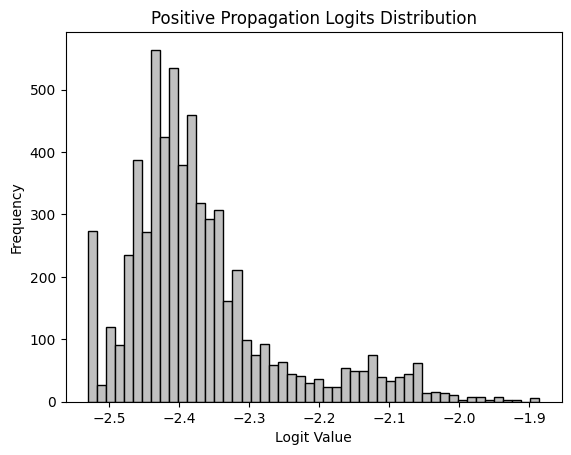

In [259]:
plt.hist(logit_p[0,2].cpu().numpy().flatten(), bins=50, fc='silver', ec='black')
plt.title('Positive Propagation Logits Distribution')
plt.xlabel('Logit Value')
plt.ylabel('Frequency')
plt.show()

In [260]:
supports[1].sum()

tensor(6186, device='cuda:0')

In [261]:
logit_p[0].shape

torch.Size([3, 6186])

In [262]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import geopandas as gpd

def plot_influence_heatmap(W: np.ndarray, node_ids_local: list[int], title: str = "Influence (target←source)"):
    M = W.shape[0]
    fig, ax = plt.subplots(figsize=(1.2*M, 1.0*M) if M<=12 else (10,8))
    im = ax.imshow(W, cmap="viridis")
    ax.set_title(title)
    ax.set_xlabel("Source (j)")
    ax.set_ylabel("Target (i)")
    ax.set_xticks(range(M)); ax.set_xticklabels(node_ids_local, rotation=90)
    ax.set_yticks(range(M)); ax.set_yticklabels(node_ids_local)
    cbar = fig.colorbar(im, ax=ax, fraction=0.02, pad=0.02)
    cbar.set_label("weight")
    plt.tight_layout(); plt.show()

def plot_influence_map(
    gdf: gpd.GeoDataFrame,
    keep_nodes: np.ndarray,  # global ids
    W: np.ndarray,           # (M,M)
    title: str = "Subgraph influence (width/color = weight)",
    vmin=None, vmax=None
):
    nodes_sub = gdf.iloc[keep_nodes].copy().reset_index(drop=True)
    M = len(nodes_sub)
    # edges from W>0
    I_list, J_list, val = [], [], []
    for i in range(M):
        for j in range(M):
            if W[i,j] > 0:
                I_list.append(i); J_list.append(j); val.append(W[i,j])
    val = np.array(val) if len(val) else np.array([0.0])

    if vmin is None: vmin = np.quantile(val, 0.05)
    if vmax is None: vmax = np.quantile(val, 0.95) if np.any(val>0) else 1.0
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.cm.viridis

    # Build line geoms
    pts = np.array([(p.x, p.y) for p in nodes_sub.geometry])
    lines = [mpl.lines.Line2D([pts[j,0], pts[i,0]], [pts[j,1], pts[i,1]], 
                              color=cmap(norm(w)), linewidth=0.5 + 3.0*(w - vmin)/max(1e-12,(vmax - vmin)),
                              alpha=0.9, zorder=2)
             for i,j,w in zip(I_list, J_list, val)]
    fig, ax = plt.subplots(figsize=(8,7))
    nodes_sub.plot(ax=ax, color="black", markersize=10, zorder=3)
    for ln in lines: ax.add_line(ln)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02); cbar.set_label("weight")
    ax.set_title(title); ax.set_axis_off(); plt.tight_layout(); plt.show()

In [55]:
from shapely.geometry import Point, box
from typing import Iterable, Tuple, Optional

In [56]:
def select_nodes_by_bbox(gdf: gpd.GeoDataFrame, xmin, ymin, xmax, ymax, limit: Optional[int]=10):
    """Return indices of nodes within bbox (optionally take first `limit`)."""
    sel = gdf.cx[xmin:xmax, ymin:ymax].index.to_numpy()
    if limit is not None and len(sel) > limit:
        sel = sel[:limit]
    return np.asarray(sel, dtype=np.int64)

In [64]:
import numpy as np
import geopandas as gpd
from shapely.geometry import LineString
from shapely.geometry.base import BaseGeometry

In [65]:
def _ensure_metric_crs(gdf: gpd.GeoDataFrame, metric_crs: int | str | None = None) -> gpd.GeoDataFrame:
    """
    Return a GeoDataFrame in a metric CRS suitable for 'meter' distances.
    If gdf is geographic (e.g., EPSG:4326) and metric_crs is None, reproject to EPSG:3857.
    """
    if gdf.crs is None:
        raise ValueError("gdf has no CRS; set gdf.set_crs(...) first.")
    if gdf.crs.is_geographic:
        target = metric_crs if metric_crs is not None else 3857  # Web Mercator
        return gdf.to_crs(target)
    return gdf

def _endpoints_of_geom(geom: BaseGeometry) -> tuple[np.ndarray, np.ndarray]:
    """
    Return (p0, p1) endpoints as np.array([x,y]) for a LineString or MultiLineString.
    For MultiLineString, uses the longest component.
    """
    if geom.geom_type == "LineString":
        coords = np.asarray(geom.coords)
        return coords[0], coords[-1]
    elif geom.geom_type == "MultiLineString":
        # pick the longest linestring
        parts = list(geom.geoms)
        if not parts:
            raise ValueError("Empty MultiLineString geometry.")
        longest = max(parts, key=lambda g: g.length)
        coords = np.asarray(longest.coords)
        return coords[0], coords[-1]
    else:
        raise TypeError(f"Unsupported geometry type: {geom.geom_type}. Expected LineString/MultiLineString.")

def _all_endpoints(gdf_metric: gpd.GeoDataFrame) -> np.ndarray:
    """
    Vectorized-ish extraction of endpoints for every row.
    Returns arr of shape (N, 2, 2): endpoints[i,0]=p0(x,y), endpoints[i,1]=p1(x,y)
    """
    out = np.zeros((len(gdf_metric), 2, 2), dtype=float)
    for i, geom in enumerate(gdf_metric.geometry):
        p0, p1 = _endpoints_of_geom(geom)
        out[i, 0] = p0
        out[i, 1] = p1
    return out

def select_roads_by_endpoint_proximity(
    gdf_roads: gpd.GeoDataFrame,
    m: int,
    K_meters: float,
    metric_crs: int | str | None = None,
) -> np.ndarray:
    """
    Return indices of roads whose BOTH endpoints are within K meters of EITHER endpoint of road m.

    Args
    ----
    gdf_roads : GeoDataFrame with LineString/MultiLineString geometries (rows aligned with your G_road order)
    m         : int, index of the reference road in gdf_roads
    K_meters  : float, distance threshold in meters
    metric_crs: optional CRS to project into (e.g., a local UTM). If None and CRS is geographic, uses EPSG:3857.

    Returns
    -------
    keep : np.ndarray of global row indices satisfying the condition (including m itself)
    """
    gdf_m = _ensure_metric_crs(gdf_roads, metric_crs)
    N = len(gdf_m)
    if not (0 <= m < N):
        raise IndexError(f"m out of range (got {m}, expected 0..{N-1}).")

    # Precompute endpoints
    endpoints = _all_endpoints(gdf_m)         # (N,2,2)
    p0_m, p1_m = _endpoints_of_geom(gdf_m.geometry.iloc[m])  # (2,), (2,)
    p0_m = np.asarray(p0_m, dtype=float)
    p1_m = np.asarray(p1_m, dtype=float)

    # Distances from every endpoint to each of m's endpoints
    # endpoints[:,0] are first endpoints; endpoints[:,1] are second endpoints
    d_u_a = np.linalg.norm(endpoints[:, 0] - p0_m, axis=1)   # dist(u, a)
    d_u_b = np.linalg.norm(endpoints[:, 0] - p1_m, axis=1)   # dist(u, b)
    d_v_a = np.linalg.norm(endpoints[:, 1] - p0_m, axis=1)   # dist(v, a)
    d_v_b = np.linalg.norm(endpoints[:, 1] - p1_m, axis=1)   # dist(v, b)

    # Condition: (u close to a or b) AND (v close to a or b)
    u_ok = (d_u_a <= K_meters) | (d_u_b <= K_meters)
    v_ok = (d_v_a <= K_meters) | (d_v_b <= K_meters)
    keep_mask = u_ok & v_ok

    keep = np.nonzero(keep_mask)[0]
    return keep

In [263]:
from collections import deque
def largest_island_from_keep(G_road: np.ndarray, keep: np.ndarray, directed: bool = True):
    """
    G_road: (N,N) binary adjacency (0/1)
    keep  : 1D array of node indices to restrict to
    directed: if True, use weak connectivity (symmetrize)
    returns: np.ndarray of node indices (subset of keep) in the largest island
    """
    keep = np.asarray(keep, dtype=np.int64)
    if keep.size == 0:
        return keep

    # Induced subgraph
    A = G_road[np.ix_(keep, keep)]
    if directed:
        A = ((A + A.T) > 0).astype(np.uint8)  # weak connectivity

    M = A.shape[0]
    visited = np.zeros(M, dtype=bool)
    best_comp = np.array([], dtype=np.int64)
    for s in range(M):
        if visited[s]:
            continue
        comp = []
        q = deque([s]); visited[s] = True
        while q:
            u = q.popleft()
            comp.append(u)
            neigh = np.flatnonzero(A[u])
            for v in neigh:
                if not visited[v]:
                    visited[v] = True
                    q.append(v)
        if len(comp) > len(best_comp):
            best_comp = np.array(comp, dtype=np.int64)

    # Map local indices back to global node IDs
    return keep[best_comp]

In [264]:
gdf_local = gdf.to_crs(epsg=3857)
keep = select_roads_by_endpoint_proximity(gdf_local, 153, 1000, metric_crs=3857)
keep = largest_island_from_keep(supports[1].cpu().numpy(), keep, directed=True)

In [265]:
keep

array([  33,   34, 1018,   35, 1017,  778,  666,  163,  293,  665,  140,
        154,  161,  162,  664,  134,  139,  141,  998,  149,  153,  155,
       1211,  132,  164,  997,  100,  148,  150,  151,  663, 1168,  101,
        108,  109,  212,  110,  213, 1196,   99,  152,  325,  156,  157,
        330,  383,  384,   97,  323,  324,  327,  328,  333,  329,  706,
        381, 1001, 1169,  334,  477,  704,  707,  708,  382,  385,  386,
        524, 1135,  789,  705,  709,  945, 1147,  790,  944,  884,  885])

In [266]:
in_steps = cfg.get("in_steps")
out_steps = cfg.get("out_steps")

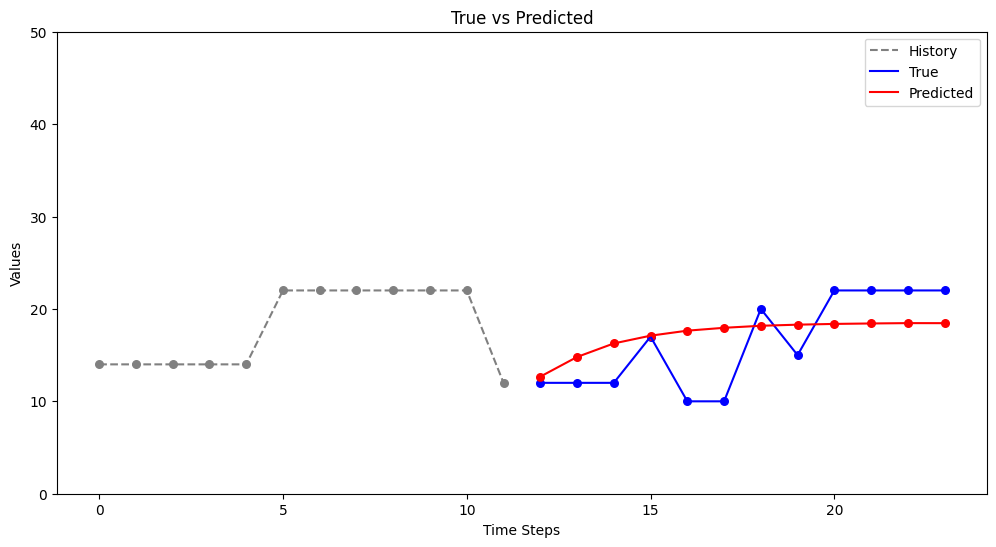

In [283]:
# --------- visualize prediction --------
import matplotlib.pyplot as plt
_node = 998
_b = 6
plt.figure(figsize=(12, 6))
plt.plot(np.arange(0, in_steps), x_history[_b, :, _node, 0], label="History", color="gray", linestyle="--")
plt.scatter(np.arange(0, in_steps), x_history[_b, :, _node, 0], color="gray", s=30)
plt.plot(np.arange(in_steps, in_steps + out_steps), y_true[_b, :, _node, 0], label="True", color="blue")
plt.scatter(np.arange(in_steps, in_steps + out_steps), y_true[_b, :, _node, 0], s=30, color="blue")
plt.plot(np.arange(in_steps, in_steps + out_steps), y_pred[_b, :, _node, 0], label="Predicted", color="red")
plt.scatter(np.arange(in_steps, in_steps + out_steps), y_pred[_b, :, _node, 0], s=30, color="red")
plt.title("True vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()
plt.ylim(0, 50)
plt.show()

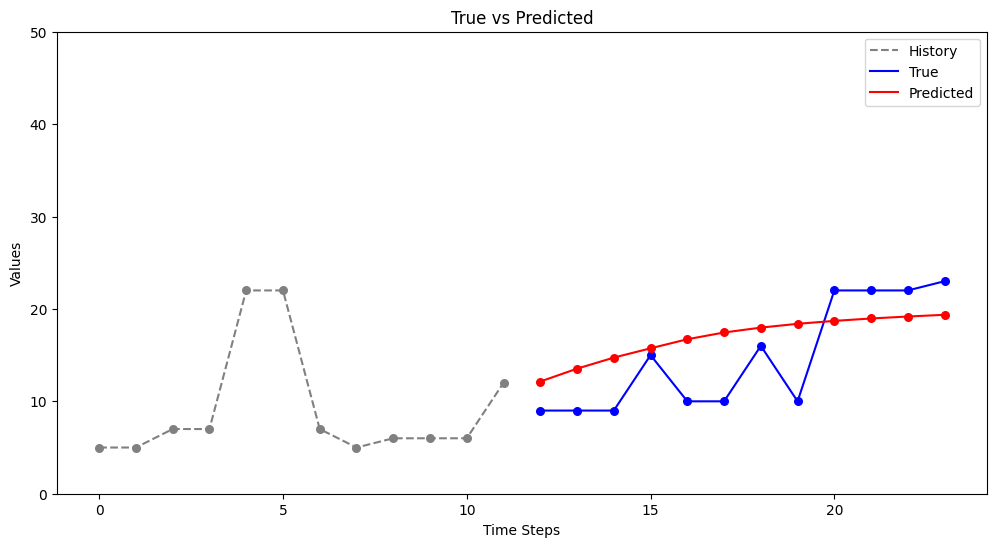

In [284]:
# --------- visualize prediction --------
import matplotlib.pyplot as plt
_node = 997
_b = 6
plt.figure(figsize=(12, 6))
plt.plot(np.arange(0, in_steps), x_history[_b, :, _node, 0], label="History", color="gray", linestyle="--")
plt.scatter(np.arange(0, in_steps), x_history[_b, :, _node, 0], color="gray", s=30)
plt.plot(np.arange(in_steps, in_steps + out_steps), y_true[_b, :, _node, 0], label="True", color="blue")
plt.scatter(np.arange(in_steps, in_steps + out_steps), y_true[_b, :, _node, 0], s=30, color="blue")
plt.plot(np.arange(in_steps, in_steps + out_steps), y_pred[_b, :, _node, 0], label="Predicted", color="red")
plt.scatter(np.arange(in_steps, in_steps + out_steps), y_pred[_b, :, _node, 0], s=30, color="red")
plt.title("True vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()
plt.ylim(0, 50)
plt.show()

array([12.,  9.], dtype=float32)

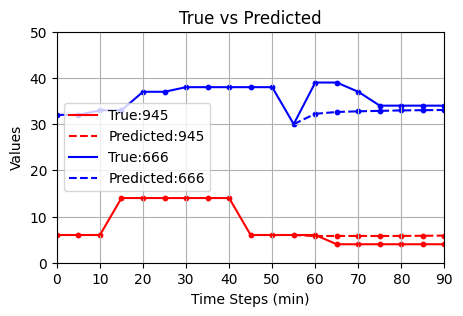

In [342]:
# --------- visualize prediction --------
import matplotlib.pyplot as plt
_b = 3

_node = 945
plt.figure(figsize=(5, 3))
connect_line = [x_history[_b, :, _node, 0][-1], y_true[_b, :, _node, 0][0]]
connect_line_1 = [x_history[_b, :, _node, 0][-1], y_pred[_b, :, _node, 0][0]]
plt.plot(np.arange(0, in_steps)*5, x_history[_b, :, _node, 0], label=f"True:{_node}", color="red")
plt.scatter(np.arange(0, in_steps)*5, x_history[_b, :, _node, 0], color="red", s=10)
plt.plot(np.arange(in_steps - 1, in_steps + 1)*5, connect_line, color="red")
plt.plot(np.arange(in_steps, in_steps + out_steps)*5, y_true[_b, :, _node, 0], color="red")
plt.scatter(np.arange(in_steps, in_steps + out_steps)*5, y_true[_b, :, _node, 0], s=10, color="red")
plt.plot(np.arange(in_steps, in_steps + out_steps)*5, y_pred[_b, :, _node, 0], label=f"Predicted:{_node}", color="red", linestyle='--')
plt.scatter(np.arange(in_steps, in_steps + out_steps)*5, y_pred[_b, :, _node, 0], s=10, color="red")
plt.plot(np.arange(in_steps - 1, in_steps + 1)*5, connect_line_1, color="red", linestyle='--')


_node = 666
connect_line = [x_history[_b, :, _node, 0][-1], y_true[_b, :, _node, 0][0]]
connect_line_1 = [x_history[_b, :, _node, 0][-1], y_pred[_b, :, _node, 0][0]]
plt.plot(np.arange(0, in_steps)*5, x_history[_b, :, _node, 0], label=f"True:{_node}", color="blue")
plt.scatter(np.arange(0, in_steps)*5, x_history[_b, :, _node, 0], color="blue", s=10)
plt.plot(np.arange(in_steps - 1, in_steps + 1)*5, connect_line, color="blue")
plt.plot(np.arange(in_steps, in_steps + out_steps)*5, y_true[_b, :, _node, 0], color="blue")
plt.scatter(np.arange(in_steps, in_steps + out_steps)*5, y_true[_b, :, _node, 0], s=10, color="blue")
plt.plot(np.arange(in_steps, in_steps + out_steps)*5, y_pred[_b, :, _node, 0], label=f"Predicted:{_node}", color="blue", linestyle='--')
plt.scatter(np.arange(in_steps, in_steps + out_steps)*5, y_pred[_b, :, _node, 0], s=10, color="blue")
plt.plot(np.arange(in_steps - 1, in_steps + 1)*5, connect_line_1, color="blue", linestyle='--')

plt.title("True vs Predicted")
plt.xlabel("Time Steps (min)")
plt.ylabel("Values")
plt.legend()
plt.ylim(0, 50)
plt.grid()
plt.xlim(0, 90)

plt.show()

In [269]:
def plot_selected_roads(gdf, keep, color_all="lightgray", color_sel="red",
                        lw_all=0.8, lw_sel=2.5, title="Selected roads"):
    """
    Plot all roads in gdf, highlighting the subset of indices in keep.
    """
    fig, ax = plt.subplots(figsize=(8, 7))
    gdf.plot(ax=ax, color=color_all, linewidth=lw_all, alpha=0.7, zorder=1)
    gdf.iloc[keep].plot(ax=ax, color=color_sel, linewidth=lw_sel, alpha=0.9, zorder=2)
    ax.set_title(title)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

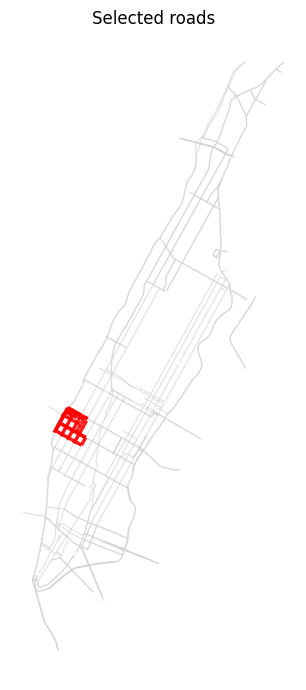

In [270]:
plot_selected_roads(gdf_local, keep)

In [271]:
import numpy as np
import geopandas as gpd
import plotly.graph_objects as go
import plotly.colors as pc

def _ensure_wgs84(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    if gdf.crs is None:
        raise ValueError("gdf has no CRS. Set gdf.crs before plotting.")
    try:
        epsg = gdf.crs.to_epsg()
    except Exception:
        epsg = None
    return gdf if epsg == 4326 else gdf.to_crs(4326)

def _node_lonlat_from_geometry(nodes_sub: gpd.GeoDataFrame):
    geoms = nodes_sub.geometry
    if (geoms.geom_type == "Point").all():
        lon = geoms.x.to_numpy()
        lat = geoms.y.to_numpy()
    else:
        reps = geoms.representative_point()
        lon = reps.x.to_numpy()
        lat = reps.y.to_numpy()
    return lon.astype(float), lat.astype(float)

def _topk_outgoing(W: np.ndarray, k: int) -> np.ndarray:
    M = W.shape[0]
    mask = np.zeros_like(W, dtype=bool)
    for j in range(M):
        col = W[:, j]
        pos = np.flatnonzero(col > 0)
        if pos.size == 0:
            continue
        k_eff = min(k, pos.size)
        top_local = np.argpartition(-col[pos], k_eff - 1)[:k_eff]
        keep_rows = pos[top_local]
        mask[keep_rows, j] = True
    return mask

def make_influence_map_interactive(
    gdf: gpd.GeoDataFrame,
    keep,
    W: np.ndarray,
    names: dict[int, str] | None = None,
    weight_threshold: float | None = None,
    topk_per_source: int | None = 5,
    line_scale: tuple[float, float] = (1.0, 6.0),
    node_size: int = 10,
    title: str = "Subgraph influence (target \u2190 source)",
    zoom: float | None = None,
    color_scale: str = "red",
) -> go.Figure:
    """Interactive map with red colorscale and colorbar legend (robust, LineString-safe)."""
    keep = np.asarray(keep, dtype=int)
    M = len(keep)
    if W.shape != (M, M):
        raise ValueError(f"W shape {W.shape} must be (M,M) with M=len(keep)={M}.")

    gdf_wgs = _ensure_wgs84(gdf)
    nodes_sub = gdf_wgs.iloc[keep].copy().reset_index(drop=True)
    lon, lat = _node_lonlat_from_geometry(nodes_sub)

    labels = [str(names.get(int(g), int(g))) if names is not None else str(int(g)) for g in keep]

    # Select edges
    W_pos = np.where(np.isfinite(W) & (W > 0), W, 0.0)
    mask = np.ones_like(W_pos, dtype=bool)
    if weight_threshold is not None:
        mask &= (W_pos >= float(weight_threshold))
    if topk_per_source and topk_per_source > 0:
        mask &= _topk_outgoing(W_pos, k=int(topk_per_source))
    ii, jj = np.where(mask & (W_pos > 0))
    weights = W_pos[ii, jj]

    fig = go.Figure()

    # --- Color/width scaling ---
    red_scale = [
        [0.0, "#ffffcc"],
        [0.25, "#ffeda0"],
        [0.5, "#feb24c"],
        [0.75, "#f03b20"],
        [1.0, "#bd0026"],
    ]
    green_scale = [
        [0.0, "#f7fcf5"],
        [0.25, "#c7e9c0"],
        [0.5, "#74c476"],
        [0.75, "#31a354"],
        [1.0, "#006d2c"],
    ]
    scale_used = green_scale if color_scale.lower().startswith("g") else red_scale
    if weights.size > 0:
        wmin = np.nanquantile(weights, 0.05)
        wmax = np.nanquantile(weights, 0.95)
        if not np.isfinite(wmin): wmin = float(np.nanmin(weights))
        if not np.isfinite(wmax): wmax = float(np.nanmax(weights))
        if wmax <= wmin: wmax = wmin + 1e-6

        norm = np.clip((weights - wmin) / (wmax - wmin), 0.0, 1.0)
        widths = line_scale[0] + (line_scale[1] - line_scale[0]) * norm
        color_strs = pc.sample_colorscale(scale_used, norm.tolist())

        # Edges
        for i, j, w, lw, color_str in zip(ii, jj, weights, widths, color_strs):
            fig.add_trace(go.Scattermapbox(
                lon=[float(lon[j]), float(lon[i])],
                lat=[float(lat[j]), float(lat[i])],
                mode="lines",
                line=dict(width=float(lw), color=str(color_str)),
                hovertemplate=(
                    "<b>source</b>: %{customdata[0]}"
                    "<br><b>target</b>: %{customdata[1]}"
                    "<br><b>Influence</b>: %{customdata[2]:.4f}<extra></extra>"
                ),
                customdata=[[labels[j], labels[i], float(w)]],
                showlegend=False
            ))

        # Colorbar via invisible marker trace (lines can't host colorbar)
        center_lon = float(np.mean(lon)) if lon.size else 0.0
        center_lat = float(np.mean(lat)) if lat.size else 0.0
        fig.add_trace(go.Scattermapbox(
            lon=[center_lon, center_lon],
            lat=[center_lat, center_lat],
            mode="markers",
            marker=dict(
                size=[0, 0],
                color=[wmin, wmax],          # span range for colorbar
                colorscale=scale_used,
                cmin=wmin, cmax=wmax,
                showscale=True,
                colorbar=dict(
                    title=dict(text="Influence strength"),
                    tickvals=[wmin, (wmin + wmax) / 2, wmax],
                    ticktext=[f"{wmin:.2f}", f"{(wmin + wmax) / 2:.2f}", f"{wmax:.2f}"],
                    ticks="outside",
                    thickness=14,
                    len=0.55,
                ),
            ),
            hoverinfo="none",
            showlegend=False
        ))

    # Nodes
    fig.add_trace(go.Scattermapbox(
        lon=lon.tolist(),
        lat=lat.tolist(),
        mode="markers+text",
        marker=dict(size=int(node_size), color="black"),
        text=labels,
        textposition="top center",
        hovertemplate="<b>node</b>: %{text}<extra></extra>",
        name="nodes"
    ))

    # Layout
    center = dict(lon=float(np.mean(lon)), lat=float(np.mean(lat))) if lon.size else dict(lon=0.0, lat=0.0)
    if zoom is None: zoom = 13
    fig.update_layout(
        title=title,
        mapbox_style="open-street-map",
        mapbox=dict(center=center, zoom=float(zoom)),
        margin=dict(l=0, r=0, t=48, b=0),
        height=700,
    )
    return fig

In [272]:
def logits_to_W(logits_E, I_loc, J_loc, M, mode="per_target_softmax", temperature=1.0):
    E = len(logits_E)
    w = logits_E.clone()
    if mode == "sigmoid":
        w = torch.sigmoid(w)
    elif mode == "per_target_softmax":
        # normalize over incoming edges for each target
        w_out = torch.zeros_like(w)
        idx_by_i = [[] for _ in range(M)]
        for e in range(E):
            idx_by_i[I_loc[e]].append(e)
        for i, idxs in enumerate(idx_by_i):
            if idxs:
                vals = w[idxs] / temperature
                w_out[idxs] = torch.softmax(vals, dim=0)
        w = w_out
    W = np.zeros((M, M), dtype=np.float32)
    W[I_loc, J_loc] = w.numpy()
    return W

In [273]:
def subgraph_edges(edge_index, keep):
    I, J = edge_index  # target, source
    mask_src = np.isin(J, keep)
    mask_dst = np.isin(I, keep)
    mask = mask_src & mask_dst
    e_idx_sub = np.nonzero(mask)[0]        # indices of kept edges in E
    I_sub, J_sub = I[mask], J[mask]        # global node IDs for subgraph
    # map global → local 0..M-1
    id2loc = {int(n): i for i, n in enumerate(keep)}
    I_loc = np.array([id2loc[int(i)] for i in I_sub])
    J_loc = np.array([id2loc[int(j)] for j in J_sub])
    return (I_loc, J_loc), e_idx_sub

In [274]:
def aggregate_logits_B_L(
    logits_BLE: torch.Tensor,  # (B,L,E)
    e_idx_sub: np.ndarray,     # indices of edges in subgraph
    lag: Optional[int] = None, # choose a lag or average over L
    batch_agg: str = "mean",   # 'mean'|'median'|'quantile'
    q: float = 0.5
) -> torch.Tensor:
    """Return (E_sub,) aggregated logits tensor on CPU."""
    x = logits_BLE[:, lag, :] if lag is not None else logits_BLE.mean(dim=1)  # (B,E)
    x = x[:, torch.as_tensor(e_idx_sub, device=x.device)]                      # (B,E_sub)
    if batch_agg == "mean":
        out = x.mean(dim=0)
    elif batch_agg == "median":
        out = x.median(dim=0).values
    elif batch_agg == "quantile":
        out = torch.quantile(x, q=q, dim=0)
    else:
        raise ValueError("batch_agg must be mean|median|quantile")
    return out.detach().cpu()

In [275]:
def adjacency_to_edge_index(G_road: np.ndarray, directed: bool = True):
    """
    Convert binary adjacency matrix (N,N) → edge_index (2,E) and E count.
    
    Args:
        G_road : np.ndarray of shape (N,N), where G[i,j] = 1 means edge j→i 
                 (or i→j, depending on your convention).
        directed : if False, automatically adds reversed edges to make it symmetric.

    Returns:
        edge_index : torch.LongTensor of shape (2, E)
        E          : int, number of edges
    """
    assert G_road.ndim == 2 and G_road.shape[0] == G_road.shape[1], "G_road must be square"
    I, J = np.nonzero(G_road)  # (target, source)
    if not directed:
        # add reverse edges if not already included
        I_rev, J_rev = J, I
        I = np.concatenate([I, I_rev])
        J = np.concatenate([J, J_rev])
    edge_index = torch.as_tensor(np.vstack([I, J]), dtype=torch.long)
    return edge_index, edge_index.shape[1]

In [276]:
edge_index,_ = adjacency_to_edge_index(supports[1].cpu().numpy(), directed=True)

In [277]:
# Step 1. find subgraph edges
(I_loc, J_loc), e_idx_sub = subgraph_edges(edge_index, keep)

In [278]:
# Step 2. aggregate logits
LAG = 1  # choose lag index to visualize
logits_E = aggregate_logits_B_L(logit_n, e_idx_sub, lag=LAG, batch_agg="mean")

In [344]:
# Step 3. build dense W
M = len(keep)
W = logits_to_W(logits_E, I_loc, J_loc, M, mode="per_target_softmax", temperature=1.0)

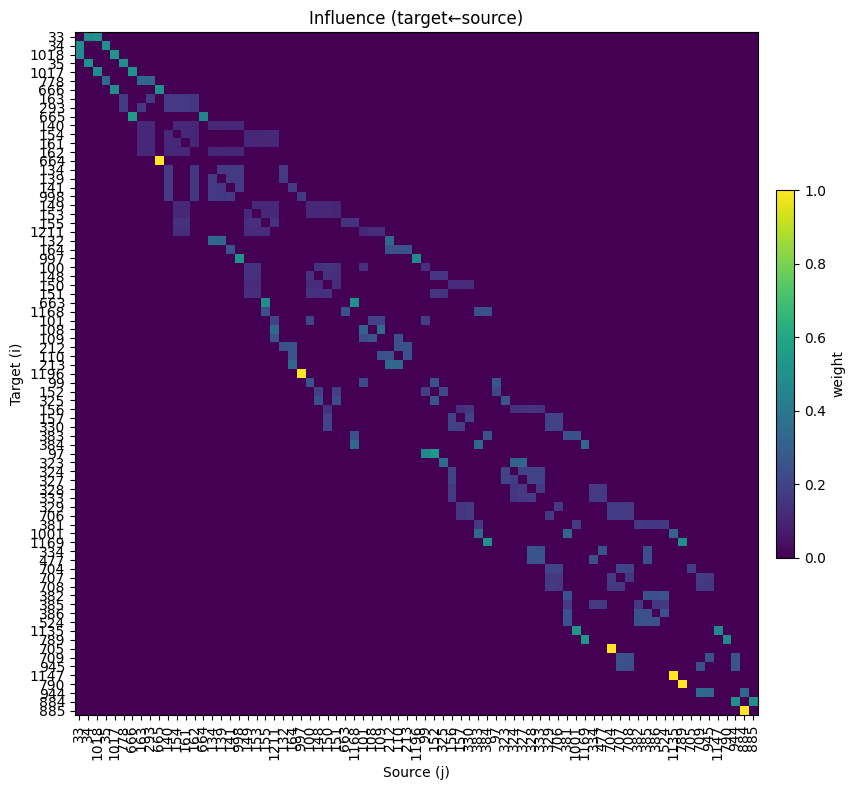

In [345]:
plot_influence_heatmap(W, keep)

In [280]:
lags = cfg["lags"]
print(f"PropSTGformer lags: {lags}")

PropSTGformer lags: [3, 6, 12]


In [346]:
import plotly.io as pio
pio.renderers.default = "browser"

fig = make_influence_map_interactive(
    gdf=gdf,
    keep=keep,      # indices into gdf for your subgraph
    W=W,            # (M,M) influence matrix
    topk_per_source=5,
    title=f"Lag {lags[LAG]*5} min: learned influence (target \u2190 source)",
    color_scale="green",
)
fig.update_layout(
    mapbox_style="mapbox://styles/mapbox/light-v11" ,
    mapbox_accesstoken="pk.eyJ1IjoibHVjYXN6dW8iLCJhIjoiY201Zndtbmh1MDIweTJqcTFhb2ZoZGZ2cSJ9.QosB9MWqjTzycQMOAR82DQ"
)
fig.show()

/tmp/ipykernel_538460/201827210.py:106: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

/tmp/ipykernel_538460/201827210.py:123: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

/tmp/ipykernel_538460/201827210.py:147: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

